# Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import keras
import keras_tuner as kt

from random import gauss
from random import seed

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from arch import arch_model

from pmdarima import auto_arima
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras_tuner import Hyperband
from keras.models import load_model,Sequential

In [3]:
df = pd.read_csv('../data/cleaned_data/master.csv',index_col=0)
df.head()

,nonglu_price,hommali_price,agri_prod_index,crops_prod_index,paddy_prod_index,nonglu_prod_index,hommali_prod_index,agri_price_index,crops_price_index,paddy_price_index,...,water_station_M7,water_station_N1,water_station_N67,water_station_Ny1B,water_station_P1,water_station_P17,water_station_S4B,water_station_Sw5A,water_station_Y17,water_station_Y1C
date,,,,,,,,,,,,,,,,,,,,,
2006-01-01,6696.0,7628.0,109.703894,114.011647,43.580672,72.649707,8.077559,110.377654,113.821771,100.581118,...,140.50,66.17,520.00,26.85,38.96,679.63,6.23,97.92,1.24,20.25
2006-02-01,6633.0,7873.0,93.049409,91.755084,46.062229,85.832560,0.000000,111.337228,115.390439,101.563145,...,87.75,39.02,501.32,26.22,64.11,573.91,4.69,69.55,0.00,13.07
2006-03-01,6649.0,7960.0,92.803780,87.828340,74.516499,138.854375,0.000000,112.498075,117.876876,103.063764,...,108.95,20.94,558.72,42.23,68.26,523.38,2.23,60.02,2.32,35.51
2006-04-01,6880.0,8028.0,75.452369,67.662286,66.215260,123.385807,0.000000,115.595159,121.878356,104.906097,...,188.40,45.73,692.79,61.08,84.68,508.65,0.06,76.80,5.84,31.54
2006-05-01,6782.0,8069.0,77.366260,68.992476,35.785484,66.682829,0.000000,113.408937,119.725058,104.687875,...,270.30,94.19,1027.25,44.98,146.19,1092.68,34.64,88.76,168.17,268.37


In [4]:
# Set index as datetime
df.index = pd.to_datetime(df.index,format="%Y-%m-%d")

In [5]:
# Check type of value
df.dtypes.value_counts()

float64    49
Name: count, dtype: int64

In [6]:
df.columns

Index(['nonglu_price', 'hommali_price', 'agri_prod_index', 'crops_prod_index',
       'paddy_prod_index', 'nonglu_prod_index', 'hommali_prod_index',
       'agri_price_index', 'crops_price_index', 'paddy_price_index',
       'nonglu_price_index', 'hommali_price_index', 'agri_export_value',
       'rice_export_value', 'ricet_export_amount', 'cpi', 'cpi_rice',
       'pol_rate', 'neer', 'reer', 'sirikit_water', 'bhumibol_water',
       'fertilizer_1', 'fertilizer_2', 'fertilizer_3', 'fertilizer_4',
       'fertilizer_5', 'fertilizer_6', 'water_station_B10',
       'water_station_C13', 'water_station_C2', 'water_station_G8',
       'water_station_K10', 'water_station_K11A', 'water_station_Kgt3',
       'water_station_Kh103', 'water_station_Kh58A', 'water_station_Kh72',
       'water_station_M6A', 'water_station_M7', 'water_station_N1',
       'water_station_N67', 'water_station_Ny1B', 'water_station_P1',
       'water_station_P17', 'water_station_S4B', 'water_station_Sw5A',
       'water_

In [7]:
df.shape

(226, 49)

# Stationarity Check

In [9]:
result = adfuller(df['nonglu_price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -3.302824716654775
p-value: 0.014752680770463844
Critical Values:
   1%: -3.4604283689894815
   5%: -2.874768966942149
   10%: -2.57382076446281


In [10]:
# ADF Statistic = -3.303
# A highly negative value generally indicates evidence against the null hypothesis 
# (non-stationarity). However, the magnitude alone is not the only determinant; 
# the test's critical values must also be considered for confirmation.

# More negative than both the 5% (-2.875) and 10% (-2.574) critical values
# But not more negative than the 1% critical value (-3.460)
# This means one can reject the null hypothesis of non-stationarity at the 5% confidence level 
# (which we're using down below) but not at the 1% level (which is basically fine here)
# The p-value of 0.015 confirms this, as it's less than 0.05 but greater than 0.01

# p-value = 0.015
# This is less than the standard 0.05 significance level
# Therefore, we reject the null hypothesis of non-stationarity
# This output justifies rejecting the null hypothesis that the series is non-stationary.

# Adds some features

In [12]:
# Calculate ratio between current price and 6-month moving average to possibly detect unusual acceleration
# Likely the most viable and valuable of the options listed
df['price_vs_6ma'] = df['nonglu_price'] / df['nonglu_price'].rolling(6).mean()

# Add lagged fertilizer prices to possibly catch early price pressure signals
# Might be noisy due to long lead time - could be adjusted?
df['fert1_lag6m'] = df['fertilizer_1'].shift(6)

# Calculate month-over-month percent changes for grain prices to possibly capture rapid market shifts
# Could be quite noisy and act more as a lagging indicator than a leading indicator
df['nonglu_mom'] = df['nonglu_price'].pct_change()
df['hommali_mom'] = df['hommali_price'].pct_change() 
df['paddy_mom'] = df['paddy_price_index'].pct_change()

# Impute NaN 
df['price_vs_6ma'].fillna(df['price_vs_6ma'].iloc[7],inplace=True)
df['fert1_lag6m'].fillna(df['fert1_lag6m'].iloc[7],inplace=True)
df['nonglu_mom'].fillna(df['nonglu_mom'].iloc[1],inplace=True)
df['hommali_mom'].fillna(df['hommali_mom'].iloc[1],inplace=True)
df['paddy_mom'].fillna(df['paddy_mom'].iloc[1],inplace=True)

import warnings
warnings.filterwarnings("ignore")

/var/folders/23/hjr1118j3slfyrxbkh5mzg300000gn/T/ipykernel_44900/1217111563.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['price_vs_6ma'].fillna(df['price_vs_6ma'].iloc[7],inplace=True)
/var/folders/23/hjr1118j3slfyrxbkh5mzg300000gn/T/ipykernel_44900/1217111563.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are

# Model

In [14]:
# Create the target
y = df['nonglu_price'].dropna()

# Define independent variables (predictors) X

# take hommali_price, paddy_price_index, cpi_rice out 
# and add 'price_vs_6ma','price_vs_6ma', 'fert1_lag6m','nonglu_mom', 'hommali_mom', 'paddy_mom'
xvars = ['agri_prod_index', 'crops_prod_index','paddy_prod_index', 
         'nonglu_prod_index', 'hommali_prod_index',
         'agri_price_index', 'crops_price_index', 'agri_export_value', 
         'ricet_export_amount', 'cpi',
         'pol_rate', 'neer', 'reer', 'sirikit_water', 'bhumibol_water',
         'fertilizer_1', 'fertilizer_2', 'fertilizer_3', 'fertilizer_4','fertilizer_5', 'fertilizer_6',
         'water_station_B10', 
         'water_station_C13', 'water_station_C2', 'water_station_G8',
         'water_station_K10', 'water_station_K11A', 'water_station_Kgt3',
         'water_station_Kh103', 'water_station_Kh58A', 'water_station_Kh72',
         'water_station_M6A', 'water_station_M7', 'water_station_N1',
         'water_station_N67', 'water_station_Ny1B', 
         'water_station_P1','water_station_P17',
         'water_station_S4B', 'water_station_Sw5A',
         'water_station_Y17', 'water_station_Y1C',
         'price_vs_6ma','price_vs_6ma', 'fert1_lag6m',
         'nonglu_mom', 'hommali_mom', 'paddy_mom']


# Adjust X to match the same periods
X = df[xvars]

# Split data into training and test sets
# shuffle=False maintains time order (crucial for time series!)
# test_size=20 reserves last 20 observations for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=25)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((201, 48), (25, 48), (201,), (25,))

In [16]:
df

,nonglu_price,hommali_price,agri_prod_index,crops_prod_index,paddy_prod_index,nonglu_prod_index,hommali_prod_index,agri_price_index,crops_price_index,paddy_price_index,...,water_station_P17,water_station_S4B,water_station_Sw5A,water_station_Y17,water_station_Y1C,price_vs_6ma,fert1_lag6m,nonglu_mom,hommali_mom,paddy_mom
date,,,,,,,,,,,,,,,,,,,,,
2006-01-01,6696.000000,7628.000000,109.703894,114.011647,43.580672,72.649707,8.077559,110.377654,113.821771,100.581118,...,679.63,6.23,97.92,1.24,20.25,0.987297,7504.0,-0.009409,0.032119,0.009764
2006-02-01,6633.000000,7873.000000,93.049409,91.755084,46.062229,85.832560,0.000000,111.337228,115.390439,101.563145,...,573.91,4.69,69.55,0.00,13.07,0.987297,7504.0,-0.009409,0.032119,0.009764
2006-03-01,6649.000000,7960.000000,92.803780,87.828340,74.516499,138.854375,0.000000,112.498075,117.876876,103.063764,...,523.38,2.23,60.02,2.32,35.51,0.987297,7504.0,0.002412,0.011050,0.014775
2006-04-01,6880.000000,8028.000000,75.452369,67.662286,66.215260,123.385807,0.000000,115.595159,121.878356,104.906097,...,508.65,0.06,76.80,5.84,31.54,0.987297,7504.0,0.034742,0.008543,0.017876
2006-05-01,6782.000000,8069.000000,77.366260,68.992476,35.785484,66.682829,0.000000,113.408937,119.725058,104.687875,...,1092.68,34.64,88.76,168.17,268.37,0.987297,7504.0,-0.014244,0.005107,-0.002080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-01,11125.917222,14942.227126,106.663154,89.776881,13.389790,24.950593,0.000000,171.023159,184.943320,176.267445,...,619.23,22.98,143.80,0.00,74.30,0.999793,16371.0,0.030054,0.035905,0.030257
2024-07-01,10954.205781,15008.641700,111.154328,90.100444,10.374035,19.331022,0.000000,164.842893,176.399651,175.174915,...,590.89,65.61,182.95,0.00,129.18,0.989840,11274.0,-0.015433,0.004445,-0.006198
2024-08-01,10761.532231,15211.289620,137.535698,130.013078,76.128953,141.859027,0.000000,163.934624,174.741785,174.825470,...,513.59,115.68,879.40,210.86,1314.93,0.987456,11408.0,-0.017589,0.013502,-0.001995


In [17]:
X_train['shock_event'] = [1 if date >= pd.to_datetime('2023-12-01') else 0 for date in y_train.index]
X_test['shock_event'] = [1 if date >= pd.to_datetime('2023-12-01')  else 0 for date in y_test.index]

# If the sharp drop can be explained through existing exogenous variables or lagged 
# effects, a shock variable may not add significant predictive value.
# If the drop reflects a unique, external event, the shock variable might be the key 
# to improving forecasts.

## 1. Linear Regression Model

In [19]:
# # Create lagged features for the dependent variable
# def create_lagged_features(data, lags):
#     df = data.copy()
#     for lag in range(1, lags + 1):
#         df[f'y_lag{lag}'] = df['nonglu_price'].shift(lag)
#     return df

# # Define the number of lags
# n_lags = 1

# # Create lagged features
# df_lagged = create_lagged_features(df[['nonglu_price']], n_lags)
# df_lagged = pd.concat([df_lagged, X], axis=1).dropna()  # Drop rows with NaNs

In [20]:
# # Redefine X and y
# y = df_lagged['nonglu_price']
# X = df_lagged.drop(columns=['nonglu_price'])

# # Split the data chronologically
# train_size = int(len(X) * 0.8)
# X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
# y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [21]:
# Evaluate the model
print(f"Training MAE: {mean_absolute_error(y_train, y_train_pred):.4f}")
print(f"Testing MAE: {mean_absolute_error(y_train, y_train_pred):.4f}")
print(f"Training MAE: {mean_absolute_error(y_test, y_test_pred):.4f}")
print(f"Testing MAE: {mean_absolute_error(y_test, y_test_pred):.4f}")

NameError: name 'mean_absolute_error' is not defined

In [ ]:
# Plot 
plt.figure(figsize=(12, 6))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed')
plt.plot(y_test_pred, c='skyblue', label='Pred Values')
plt.legend()
plt.show()

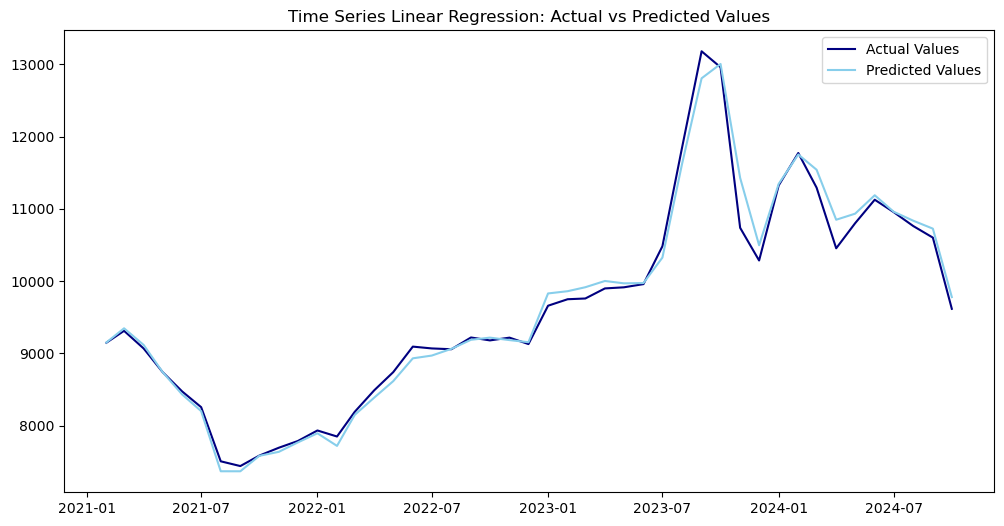

In [118]:
# Plot predictions
plt.figure(figsize=(12, 6))

plt.plot(y_test.index, y_test, label="Actual Values", color='navy')
plt.plot(y_test.index, y_test_pred, label="Predicted Values", color='skyblue')
plt.legend()
plt.title("Time Series Linear Regression: Actual vs Predicted Values")
plt.show()

## 2. ARIMA Model

### Model 2 : ARIMA

In [138]:
# Create the target
y = df['nonglu_price'].dropna()

# Define independent variables (predictors) X

# take hommali_price, paddy_price_index, cpi_rice out 
# and add 'price_vs_6ma','price_vs_6ma', 'fert1_lag6m','nonglu_mom', 'hommali_mom', 'paddy_mom'
xvars = ['agri_prod_index', 'crops_prod_index','paddy_prod_index', 
         'nonglu_prod_index', 'hommali_prod_index',
         'agri_price_index', 'crops_price_index', 'agri_export_value', 
         'ricet_export_amount', 'cpi',
         'pol_rate', 'neer', 'reer', 'sirikit_water', 'bhumibol_water',
         'fertilizer_1', 'fertilizer_2', 'fertilizer_3', 'fertilizer_4','fertilizer_5', 'fertilizer_6',
         'water_station_B10', 
         'water_station_C13', 'water_station_C2', 'water_station_G8',
         'water_station_K10', 'water_station_K11A', 'water_station_Kgt3',
         'water_station_Kh103', 'water_station_Kh58A', 'water_station_Kh72',
         'water_station_M6A', 'water_station_M7', 'water_station_N1',
         'water_station_N67', 'water_station_Ny1B', 
         'water_station_P1','water_station_P17',
         'water_station_S4B', 'water_station_Sw5A',
         'water_station_Y17', 'water_station_Y1C',
         'price_vs_6ma','price_vs_6ma', 'fert1_lag6m',
         'nonglu_mom', 'hommali_mom', 'paddy_mom']


# Adjust X to match the same periods
X = df[xvars]

# Split data into training and test sets
# shuffle=False maintains time order (crucial for time series!)
# test_size=20 reserves last 20 observations for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=25)

In [140]:
# Fit an ARIMA model with exogenous variables (also called ARIMAX)
y_train.index.freq = 'MS'
X_train.index.freq = 'MS'

arimax1_model = ARIMA(
    y_train,                 # Dependent variable (nonglu_price)
    exog=X_train,            # External variables 
    order=(2, 1, 2)).fit()   # ARIMA parameters: (p=2, d=1, q=2)

In [141]:
arimax1_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           nonglu_price   No. Observations:                  201
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1276.461
Date:                Mon, 16 Dec 2024   AIC                           2658.921
Time:                        21:52:57   BIC                           2833.732
Sample:                    01-01-2006   HQIC                          2729.664
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
agri_prod_index        -0.0052      7.393     -0.001      0.999     -14.495      14.484
crops_prod_index        1.0932      5.718      0.191      0.848     -10.113      12.300
paddy_prod_index       -0.0931      1.528     -0.061      0.951      -3.088       2.902
nonglu_prod_index      -0.2372      1.047     -0.227      0.821      -2.290       1.816
hommali_prod_index     -0.0820      0.572     -0.143      0.886      -1.203       1.039
agri_price_index      -40.5782     30.503     -1.330      0.183    -100.363      19.206
crops_price_index      34.3908     22.492      1.529      0.126      -9.693      78.475
agri_export_value       0.2394      0.123      1.940      0.052      -0.002       0.481
ricet_export_amount    -0.0002      0.000     -1.696      0.090      -0.000    3.28e-05
cpi                    17.9412     86.022      0.209      0.835    -150.659     186.542
pol_rate              100.6468    202.371      0.497      0.619    -295.994     497.287
neer                  -51.0980     80.284     -0.636      0.524    -208.452     106.255
reer                   52.4645     81.031      0.647      0.517    -106.354     211.283
sirikit_water           0.0198      0.301      0.066      0.948      -0.570       0.609
bhumibol_water          0.0967      0.098      0.986      0.324      -0.095       0.289
fertilizer_1           -0.0556      0.052     -1.077      0.282      -0.157       0.046
fertilizer_2           -0.0027      0.039     -0.069      0.945      -0.079       0.073
fertilizer_3            0.0331      0.046      0.726      0.468      -0.056       0.123
fertilizer_4            0.0025      0.022      0.110      0.913      -0.042       0.047
fertilizer_5            0.0747      0.047      1.600      0.110      -0.017       0.166
fertilizer_6           -0.0104      0.031     -0.339      0.735      -0.071       0.050
water_station_B10      -0.1408      0.558     -0.252      0.801      -1.235       0.953
water_station_C13       0.0368      0.054      0.682      0.495      -0.069       0.143
water_station_C2       -0.0059      0.083     -0.071      0.944      -0.169       0.158
water_station_G8       -0.3159      0.806     -0.392      0.695      -1.895       1.263
water_station_K10      -0.0768      0.128     -0.600      0.548      -0.328       0.174
water_station_K11A     -0.0418      0.092     -0.454      0.649      -0.222       0.139
water_station_Kgt3      0.2321      0.104      2.237      0.025       0.029       0.435
water_station_Kh103     1.2137      1.103      1.100      0.271      -0.948       3.375
water_station_Kh58A    -0.2997      0.253     -1.184      0.236      -0.796       0.196
water_station_Kh72      1.1220      1.874      0.599      0.549      -2.552       4.796
water_station_M6A       0.0104      0.064      0.162      0.871      -0.115       0.136
water_station_M7       -0.0142      0.024     -0.586      0.558      -0.062       0.033
water_station_N1       -0.0326      0.384     -0.085      0.932      -0.7

In [142]:
# Generate predictions on the test set
arimax1_forecast = arimax1_model.predict(
   start=X_test.index[0],    # Start forecasting from first test observation
   end=X_test.index[-1],     # Continue until last test observation
   exog=X_test)

In [143]:
# Evaluate the arima model
print(f"MSE : {mean_squared_error(y_test, arimax1_forecast):.4f}")
print(f"RMSE :{root_mean_squared_error(y_test, arimax1_forecast):.4f}")

MSE : 1573439.2557
RMSE :1254.3681


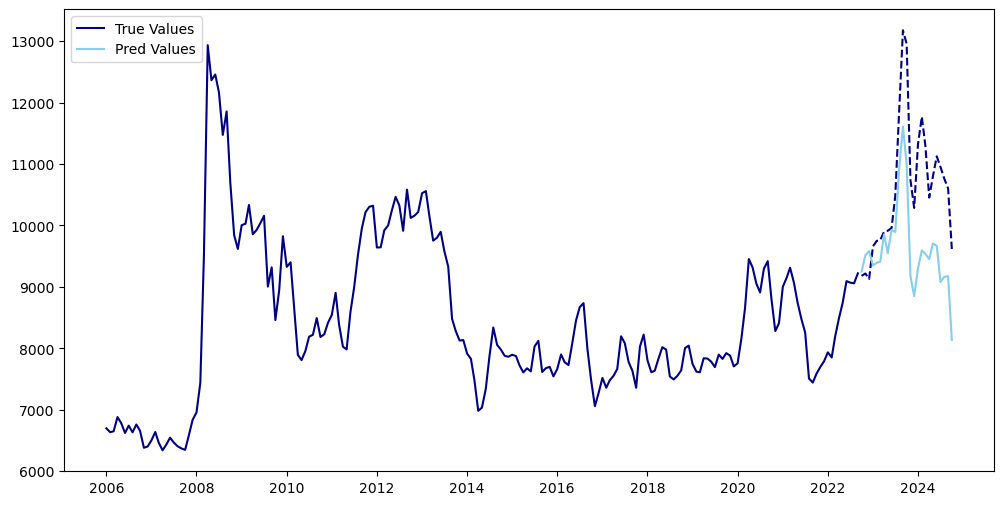

In [144]:
# Plot 
plt.figure(figsize=(12, 6))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed')
plt.plot(arimax1_forecast, c='skyblue', label='Pred Values')
plt.legend()
# saving the plot as an image
plt.savefig('timeseries_plot.png')
plt.show()

### Model 3 : Auto ARIMA

In [ ]:
# Automatically tune ARIMA parameters
auto_model = auto_arima(
    y_train,exogenous=X_train,
    start_p=0, max_p=4,
    start_q=0, max_q=4,
    d=None,seasonal=False, trace=False,error_action='ignore', suppress_warnings=True, stepwise=True)

# Best parameters
print(auto_model.summary())

In [ ]:
# Fit an ARIMA model with exogenous variables (also called ARIMAX)
y_train.index.freq = 'MS'
X_train.index.freq = 'MS'

arimax2_model = ARIMA(
    y_train,           # Dependent variable (nonglu_price)
    exog = X_train,    # External variables 
    order = (2, 0, 0), # ARIMA parameters: (p=2, d=0, q=0)
).fit()

# Get the residual
arimax2_model_residuals = arimax2_model.resid

# Generate predictions on the test set
arimax2_forecast = arimax2_model.predict(
   start=X_test.index[0],    # Start forecasting from first test observation
   end=X_test.index[-1],     # Continue until last test observation
   exog=X_test)

In [ ]:
# Evaluate the model_3
print(f"MSE : {mean_squared_error(y_test, arimax2_forecast):.4f}")
print(f"RMSE :{root_mean_squared_error(y_test, arimax2_forecast):.4f}")

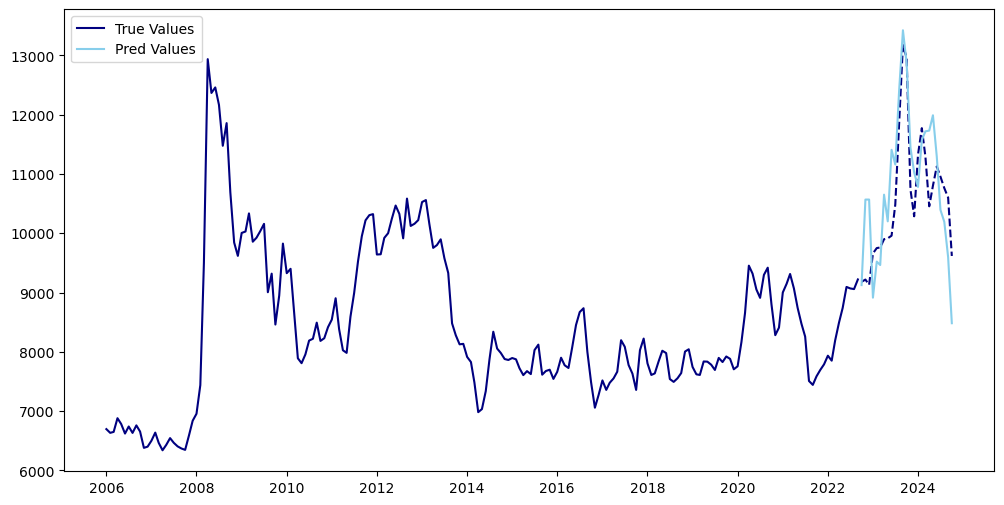

In [265]:
# Plot 
plt.figure(figsize=(12, 6))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed')
plt.plot(arimax2_forecast, c='skyblue', label='Pred Values')
plt.legend()
plt.show()

## 3. ARIMAX + GARCH Model

### Model 4 : ARIMAX + GARCH

In [326]:
# Seed pseudorandom number generator
seed(1)

# Define model - fit on the residuals.
garch_model = arch_model(arimax2_model_residuals, mean='Zero', vol='GARCH', p=1, q=1, rescale=False)

# Fit model
garch_model_fit = model.fit(disp='off')

# forecast the test set
garch_forecast = garch_model_fit.forecast(horizon=len(y_test), reindex=False)
garch_volatility = np.sqrt(garch_forecast.variance.values[-1])  # Convert to standard deviation

arimax_forecast = garch_model.get_forecast(steps=len(y_test), exog=X_test)
arimax_mean = arimax_forecast.predicted_mean

# combine ARIMAX Mean and GARCH Volatility
yhat = arimax_mean + garch_volatility  # Add GARCH volatility directly

NameError: name 'arimax2_model_residuals' is not defined

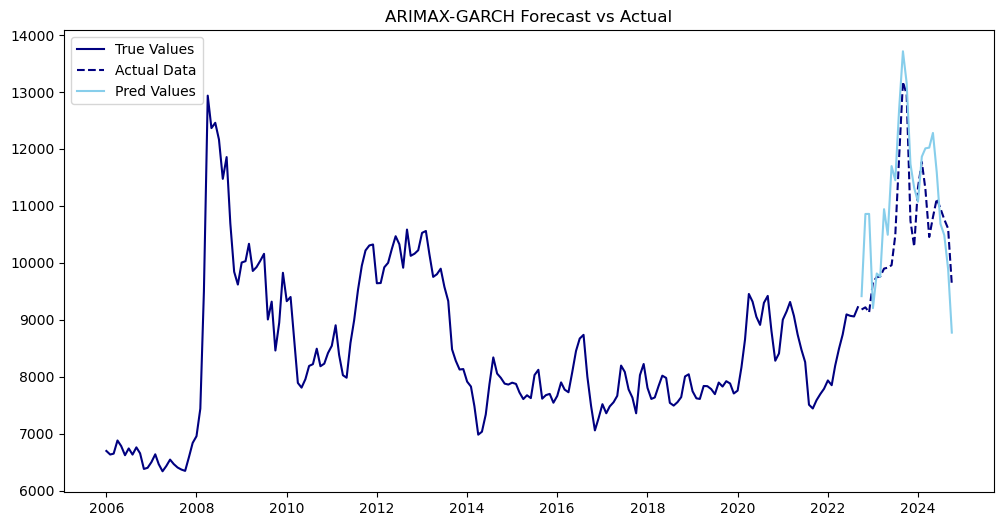

In [269]:
plt.figure(figsize=(12, 6))
plt.plot(y_train, c='navy', label="True Values")
plt.plot(y_test.index, y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(y_test.index, yhat, c='skyblue', label="Pred Values")
plt.legend()
plt.title("ARIMAX-GARCH Forecast vs Actual")
plt.show()